In [1]:
! pip install langgraph langsmith langchain langchain_groq langchain_community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 340.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.5/113.5 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.9/296.9 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.0/408.0 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3

In [3]:
!pip install arxiv wikipedia

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 9.2 MB/s eta 0:00:00
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=0ff73cca951ba2e14d62078c601b89cb099608bdc28b5a87eee84614e5fe1618
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=b82ff97849a3d2bde62a43d4005b3df99b4a87976dbca7a0896501628acf3f25
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built wikipedia sgmllib3k


In [4]:
## for state class
from typing import Annotated
from typing_extensions import TypedDict

In [5]:
## Tools
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain.tools import ArxivQueryRun, WikipediaQueryRun


arxiv_wrapper = ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wrapper)

wikipedia_wrapper = WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wikipedia_tool = WikipediaQueryRun(api_wrapper=wikipedia_wrapper)



In [6]:
wikipedia_tool.invoke("Who is Monkey D Luffy")

'Page: Monkey D. Luffy\nSummary: Monkey D. Luffy ( LOO-fee) (Japanese: モンキー・D・ルフィ, Hepburn: Monkī Dī Rufi, [ɾɯꜜɸiː]), also known as "Straw Hat" Luffy, is a fictional character and the protagonist in the Japanese manga series One Piece created by Eiichiro Oda. Luffy made his debut as a young boy who ac'

In [9]:
arxiv_tool.invoke("Attention is All you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

In [10]:
tools = [wikipedia_tool]

In [11]:
from langgraph.graph.message import add_messages
class State(TypedDict):
  messages:Annotated[list,add_messages]

In [12]:
from langgraph.graph import StateGraph,START,END
graph_builder = StateGraph(State)

In [13]:
from langchain_groq import ChatGroq

In [14]:
from google.colab import userdata
groq_api_key = userdata.get('GROQ_API_KEY')

In [15]:
llm = ChatGroq(groq_api_key=groq_api_key,model_name = "Gemma2-9b-It")

In [16]:
llm_w_tools = llm.bind_tools(tools=tools)

In [17]:
def groqchatbot(state:State):
  return {"messages":[llm_w_tools.invoke(state["messages"])]}

In [18]:
from langgraph.prebuilt import ToolNode,tools_condition

In [19]:
# Flow

graph_builder.add_node("groqchatbot",groqchatbot)
graph_builder.add_edge(START,"groqchatbot")

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools",tool_node)

graph_builder.add_conditional_edges(
    "groqchatbot",
    tools_condition

    )

graph_builder.add_edge("tools","groqchatbot")
graph_builder.add_edge("groqchatbot",END)



In [20]:
graph = graph_builder.compile()

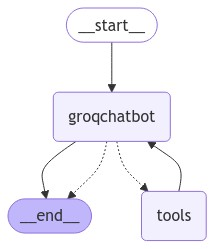

In [21]:
from IPython.display import Image,display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [23]:
user_input = "Who is Monkey D Luffy?"

events = graph.stream(
    {"messages": [("user", user_input)]},stream_mode = "values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Who is Monkey D Luffy?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_t1xx)
 Call ID: call_t1xx
  Args:
    query: Monkey D. Luffy
================================= Tool Message =================================
Name: wikipedia

Page: Monkey D. Luffy
Summary: Monkey D. Luffy ( LOO-fee) (Japanese: モンキー・D・ルフィ, Hepburn: Monkī Dī Rufi, [ɾɯꜜɸiː]), also known as "Straw Hat" Luffy, is a fictional character and the protagonist in the Japanese manga series One Piece created by Eiichiro Oda. Luffy made his debut as a young boy who ac
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_8kt6)
 Call ID: call_8kt6
  Args:
    query: Monkey D. Luffy
================================= Tool Message =================================
Name: wikipedia

Page: Monkey D. Luffy
Summary: Monkey D. Luffy ( LOO-f